Copyright 2021 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

     https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

# Colab demonstration of KIP and Label Solve algorithms

This colab implements the KIP (Kernel Inducing Point) and Label Solve algorithms introduced in the paper [Dataset Metalearning from Kernel Ridge-Regression](https://arxiv.org/abs/2011.00050). These algorithms allow for dataset distillation, which produces a small subset of learned images and/or labels which when trained upon perform as well as a much larger dataset for image classification classification tasks. 

# Imports

In [ ]:
import functools

from jax.experimental import optimizers
import jax
import jax.config
from jax.config import config as jax_config
jax_config.update('jax_enable_x64', True) # for numerical stability, can disable if not an issue
from jax import numpy as jnp
from jax import scipy as sp
import numpy as np
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
!pip install -q git+https://www.github.com/google/neural-tangents

In [ ]:
import neural_tangents as nt
from neural_tangents import stax

# Define Parameters

In [ ]:
# architecture params
ARCHITECTURE = 'FC' #@param ['FC', 'Conv', 'Myrtle']; choice of neural network architecture yielding the corresponding NTK
DEPTH =  1#@param {'type': int}; depth of neural network
WIDTH = 1024 #@param {'type': int}; width of finite width neural network; only used if parameterization is 'standard'
PARAMETERIZATION = 'ntk' #@param ['ntk', 'standard']; whether to use standard or NTK parameterization, see https://arxiv.org/abs/2001.07301

# dataset
DATASET = 'cifar10' #@param ['cifar10', 'mnist']

# training params
LEARNING_RATE = 4e-2 #@param {'type': float};
SUPPORT_SIZE = 100  #@param {'type': int}; number of images to learn
TARGET_BATCH_SIZE = 5000  #@param {'type': int}; number of target images to use in KRR for each step
LEARN_LABELS = False #@param {'type': bool}; whether to optimize over support labels during training

# Load Data

In [ ]:
def get_tfds_dataset(name):
  assert name in ['cifar10', 'mnist']
  ds_train, ds_test = tfds.as_numpy(
      tfds.load(
          name,
          split=['train', 'test'],
          batch_size=-1,
          as_dataset_kwargs={'shuffle_files': False}))

  return ds_train['image'], ds_train['label'], ds_test['image'], ds_test['label']

def one_hot(x,
            num_classes,
            center=True,
            dtype=np.float32):
  assert len(x.shape) == 1
  one_hot_vectors = np.array(x[:, None] == np.arange(num_classes), dtype)
  if center:
    one_hot_vectors = one_hot_vectors - 1. / num_classes
  return one_hot_vectors

def get_normalization_data(arr):
  channel_means = np.mean(arr, axis=(0, 1, 2))
  channel_stds = np.std(arr, axis=(0, 1, 2))
  return channel_means, channel_stds

def normalize(arr, mean, std):
  return (arr - mean) / std


X_TRAIN_RAW, LABELS_TRAIN, X_TEST_RAW, LABELS_TEST = get_tfds_dataset(DATASET)
channel_means, channel_stds = get_normalization_data(X_TRAIN_RAW)
X_TRAIN, X_TEST = normalize(X_TRAIN_RAW, channel_means, channel_stds), normalize(X_TEST_RAW, channel_means, channel_stds) 
Y_TRAIN, Y_TEST = one_hot(LABELS_TRAIN, 10), one_hot(LABELS_TEST, 10) 

# Define Kernel

In [ ]:
# define architectures

def FullyConnectedNetwork( 
    depth,
    width,
    W_std = np.sqrt(2), 
    b_std = 0.1,
    num_classes = 10,
    parameterization = 'ntk',
    activation = 'relu'):
  """Returns neural_tangents.stax fully connected network."""
  activation_fn = stax.Relu()
  dense = functools.partial(
      stax.Dense, W_std=W_std, b_std=b_std, parameterization=parameterization)

  layers = [stax.Flatten()]
  for _ in range(depth):
    layers += [dense(width), activation_fn]
  layers += [stax.Dense(num_classes, W_std=W_std, b_std=b_std)]

  return stax.serial(*layers)

def FullyConvolutionalNetwork( 
    depth,
    width,
    W_std = np.sqrt(2), 
    b_std = 0.1,
    num_classes = 10,
    parameterization = 'ntk',
    activation = 'relu'):
  """Returns neural_tangents.stax fully convolutional network."""
  activation_fn = stax.Relu()
  conv = functools.partial(
      stax.Conv,
      W_std=W_std,
      b_std=b_std,
      padding='SAME',
      parameterization=parameterization)

  for _ in range(depth):
    layers += [conv(width, (3,3)), activation_fn]
  layers += [stax.Flatten(), stax.Dense(num_classes, W_std=W_std, b_std=b_std)]

  return stax.serial(*layers)

def MyrtleNetwork(  
    depth,
    width,
    W_std = np.sqrt(2), 
    b_std = 0.1,
    num_classes = 10,
    parameterization = 'ntk',
    activation = 'relu'):
  """Returns neural_tangents.stax Myrtle network."""
  layer_factor = {5: [1, 1, 1], 7: [1, 2, 2], 10: [2, 3, 3]}
  if depth not in layer_factor.keys():
    raise NotImplementedError(
        'Myrtle network withd depth %d is not implemented!' % depth)
  activation_fn = stax.Relu()
  layers = []
  conv = functools.partial(
      stax.Conv,
      W_std=W_std,
      b_std=b_std,
      padding='SAME',
      parameterization=parameterization)
  layers += [conv(width, (3, 3)), activation_fn]

  # generate blocks of convolutions followed by average pooling for each
  # layer of layer_factor except the last
  for block_depth in layer_factor[depth][:-1]:
    for _ in range(block_depth):
      layers += [conv(width, (3, 3)), activation_fn]
    layers += [stax.AvgPool((2, 2), strides=(2, 2))]

  # generate final blocks of convolution followed by global average pooling
  for _ in range(layer_factor[depth][-1]):
    layers += [conv(width, (3, 3)), activation_fn]
  layers += [stax.GlobalAvgPool()]

  layers += [
      stax.Dense(num_classes, W_std, b_std, parameterization=parameterization)
  ]

  return stax.serial(*layers)

def get_kernel_fn(architecture, depth, width, parameterization):
  if architecture == 'FC':
    return FullyConnectedNetwork(depth=depth, width=width, parameterization=parameterization)
  elif architecture == 'Conv':
    return FullyConvolutionalNetwork(depth=depth, width=width, parameterization=parameterization)
  elif architecture == 'Myrtle':
    return MyrtleNetwork(depth=depth, width=width, parameterization=parameterization)
  else:
    raise NotImplementedError(f'Unrecognized architecture {architecture}')

In [ ]:
_, _, kernel_fn = get_kernel_fn(ARCHITECTURE, DEPTH, WIDTH, PARAMETERIZATION)
KERNEL_FN = functools.partial(kernel_fn, get='ntk')

# Run KIP

In [ ]:
def class_balanced_sample(sample_size: int, 
                          labels: np.ndarray,
                          *arrays: np.ndarray, **kwargs: int):
  """Get random sample_size unique items consistently from equal length arrays.

  The items are class_balanced with respect to labels.

  Args:
    sample_size: Number of elements to get from each array from arrays. Must be
      divisible by the number of unique classes
    labels: 1D array enumerating class label of items
    *arrays: arrays to sample from; all have same length as labels
    **kwargs: pass in a seed to set random seed

  Returns:
    A tuple of indices sampled and the corresponding sliced labels and arrays
  """
  if labels.ndim != 1:
    raise ValueError(f'Labels should be one-dimensional, got shape {labels.shape}')
  n = len(labels)
  if not all([n == len(arr) for arr in arrays[1:]]):
    raise ValueError(f'All arrays to be subsampled should have the same length. Got lengths {[len(arr) for arr in arrays]}')
  classes = np.unique(labels)
  n_classes = len(classes)
  n_per_class, remainder = divmod(sample_size, n_classes)
  if remainder != 0:
    raise ValueError(
        f'Number of classes {n_classes} in labels must divide sample size {sample_size}.'
    )
  if kwargs.get('seed') is not None:
    np.random.seed(kwargs['seed'])
  inds = np.concatenate([
      np.random.choice(np.where(labels == c)[0], n_per_class, replace=False)
      for c in classes
  ])
  return (inds, labels[inds].copy()) + tuple(
      [arr[inds].copy() for arr in arrays])

def make_loss_acc_fn(kernel_fn):

  @jax.jit
  def loss_acc_fn(x_support, y_support, x_target, y_target, reg=1e-6):
    y_support = jax.lax.cond(LEARN_LABELS, lambda y: y, jax.lax.stop_gradient, y_support)
    k_ss = kernel_fn(x_support, x_support)
    k_ts = kernel_fn(x_target, x_support)
    k_ss_reg = (k_ss + jnp.abs(reg) * jnp.trace(k_ss) * jnp.eye(k_ss.shape[0]) / k_ss.shape[0])
    pred = jnp.dot(k_ts, sp.linalg.solve(k_ss_reg, y_support, sym_pos=True))
    mse_loss = 0.5*jnp.mean((pred - y_target) ** 2)
    acc = jnp.mean(jnp.argmax(pred, axis=1) == jnp.argmax(y_target, axis=1))
    return mse_loss, (mse_loss, acc)

  return loss_acc_fn

def get_update_functions(init_params, kernel_fn, lr):
  opt_init, opt_update, get_params = optimizers.adam(lr) 
  opt_state = opt_init(init_params)
  loss_acc_fn = make_loss_acc_fn(kernel_fn)
  grad_loss = jax.grad(lambda params, x_target, y_target: loss_acc_fn(params['x'],
                                                                       params['y'],
                                                                       x_target,
                                                                       y_target), has_aux=True)

  @jax.jit
  def update_fn(step, opt_state, params, x_target, y_target):
    dparams, aux = grad_loss(params, x_target, y_target)
    return opt_update(step, dparams, opt_state), aux

  return opt_state, get_params, update_fn

def train(num_train_steps, log_freq=20, seed=1):

  _, labels_init, x_init_raw, y_init = class_balanced_sample(SUPPORT_SIZE, LABELS_TRAIN, X_TRAIN_RAW, Y_TRAIN, seed=seed)
  x_init = normalize(x_init_raw, channel_means, channel_stds)
  params_init = {'x': x_init, 'y': y_init}
  params_init_raw = {'x': x_init_raw, 'y': labels_init}

  opt_state, get_params, update_fn = get_update_functions(params_init, KERNEL_FN, LEARNING_RATE)
  params = get_params(opt_state)
  loss_acc_fn = make_loss_acc_fn(KERNEL_FN)

  _, (test_loss, test_acc) = loss_acc_fn(params['x'], params['y'], X_TEST, Y_TEST)  # compute in batches for expensive kernels
  print('initial test loss:', test_loss)
  print('initial test acc:', test_acc)

  for i in range(1,num_train_steps+1):
    # full batch gradient descent
    _, _, x_target_batch, y_target_batch = class_balanced_sample(TARGET_BATCH_SIZE, LABELS_TRAIN, X_TRAIN, Y_TRAIN) 
    opt_state, aux = update_fn(i, opt_state, params, x_target_batch, y_target_batch)
    train_loss, train_acc = aux
    params = get_params(opt_state)
    if i % log_freq == 0:
      print(f'----step {i}:')
      print('train loss:', train_loss)
      print('train acc:', train_acc)
      _, (test_loss, test_acc) = loss_acc_fn(params['x'], params['y'], X_TEST, Y_TEST)  # compute in batches for expensive kernels
      print('test loss:', test_loss)
      print('test acc:', test_acc)

  return params, params_init, params_init_raw

## Run KIP to learn SUPPORT_SIZE=100 number of images using FC1 kernel. Algorithm converges rapidly (less than 300 training steps needed in below run).

In [ ]:
params_final, params_init, params_init_raw = train(300)

initial test loss: 0.048818450774644556
initial test acc: 0.2426
----step 20:
train loss: 0.03785347937948391
train acc: 0.4174
test loss: 0.038064773902192796
test acc: 0.4141
----step 40:
train loss: 0.037208141007426344
train acc: 0.443
test loss: 0.03733862216159304
test acc: 0.4293
----step 60:
train loss: 0.03688577204766352
train acc: 0.4424
test loss: 0.03694839343387876
test acc: 0.4385
----step 80:
train loss: 0.03635759223043413
train acc: 0.4636
test loss: 0.03674279975773716
test acc: 0.44680000000000003
----step 100:
train loss: 0.035619799737885635
train acc: 0.48140000000000005
test loss: 0.03655465005325452
test acc: 0.4544
----step 120:
train loss: 0.036080339782020174
train acc: 0.4716
test loss: 0.03634762177274636
test acc: 0.4587
----step 140:
train loss: 0.035626511149871726
train acc: 0.4818
test loss: 0.03626113669439228
test acc: 0.45730000000000004
----step 160:
train loss: 0.03544180547634582
train acc: 0.4844
test loss: 0.03618743231125154
test acc: 0.45690

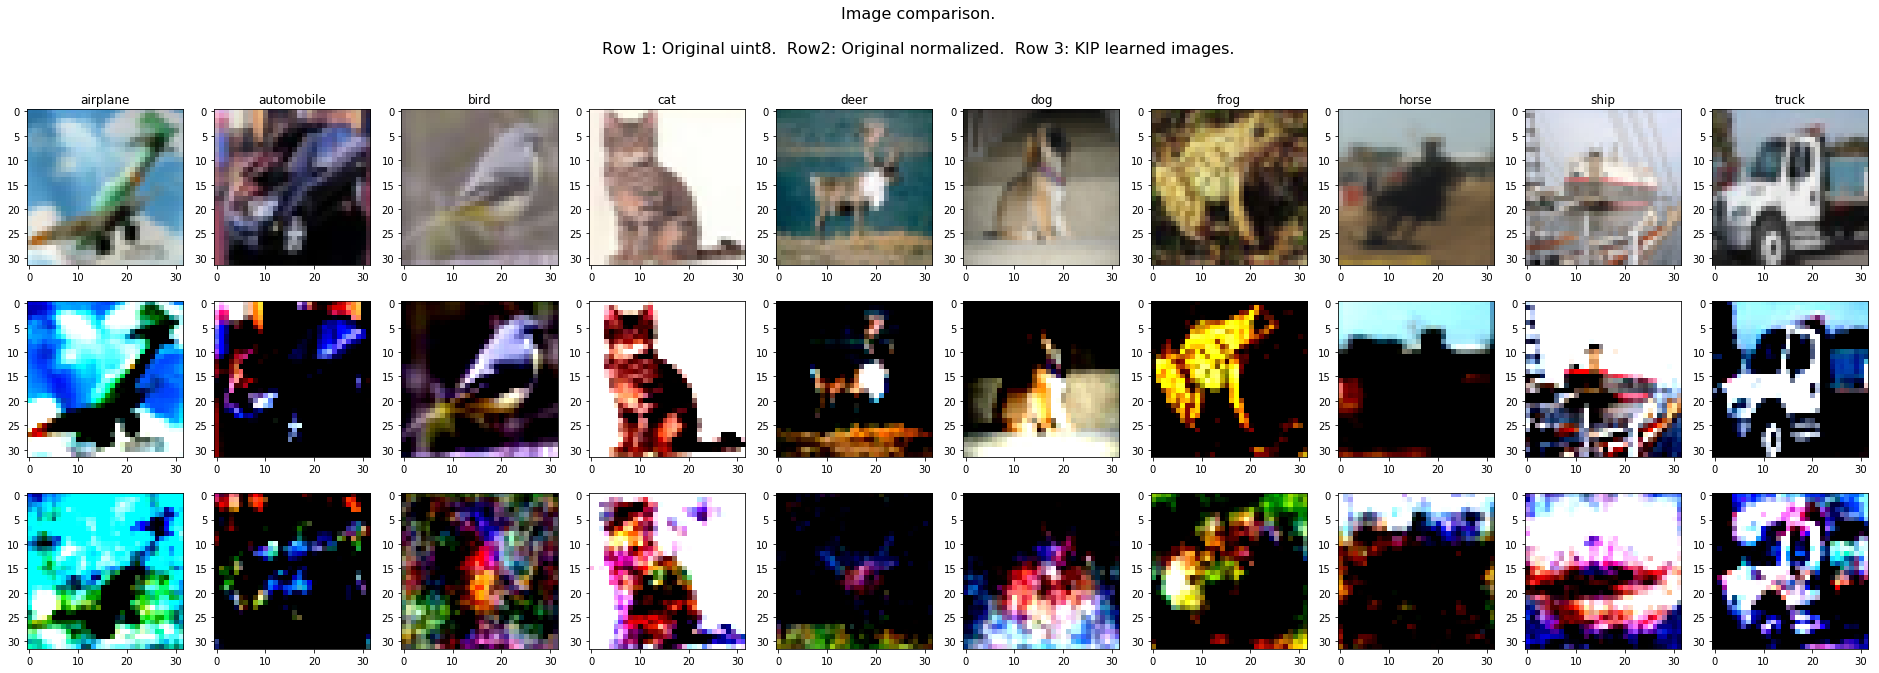

In [ ]:
_, _, sample_raw, sample_init, sample_final = class_balanced_sample(10, params_init_raw['y'], params_init_raw['x'], params_init['x'], params_final['x'], seed=3)
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

fig = plt.figure(figsize=(33,10))
fig.suptitle('Image comparison.\n\nRow 1: Original uint8.  Row2: Original normalized.  Row 3: KIP learned images.', fontsize=16, y=1.02)
for i, img in enumerate(sample_raw):
  ax = plt.subplot(3, 10, i+1)
  ax.set_title(class_names[i])
  plt.imshow(np.squeeze(img))

for i, img in enumerate(sample_init, 1):
  plt.subplot(3, 10, 10+i)
  plt.imshow(np.squeeze(img))

for i, img in enumerate(sample_final, 1):
  plt.subplot(3, 10, 20+i)
  plt.imshow(np.squeeze(img))

# Run Label Solve

In [ ]:
def make_label_solve_fn(kernel_fn):

  @jax.jit
  def label_solve(x_support, x_target, y_target, reg=1e-6):
    """Formula for label solve valid when |x_support| <= |x_target|. A regularized version of the pseudo-inverse is used for numerical stability."""
    kss = kernel_fn(x_support, x_support)
    kst = kernel_fn(x_support, x_target)
    matrix = jnp.dot(kst, kst.T)
    matrix_reg = matrix + reg * jnp.eye(matrix.shape[0])/matrix.shape[0]
    reg_pinv = sp.linalg.solve(matrix_reg, jnp.dot(kst, y_target), sym_pos=True)
    return jnp.dot(kss + reg* jnp.eye(kss.shape[0])/kss.shape[0], reg_pinv)

  return label_solve

## Label solve using 500 cifar10 images using FC1 kernel

In [ ]:
_, _, x_support, y_support = class_balanced_sample(500, LABELS_TRAIN, X_TRAIN, Y_TRAIN, seed=2021)
solved_labels = make_label_solve_fn(KERNEL_FN)(x_support, X_TEST, Y_TEST)

loss_acc_fn = make_loss_acc_fn(KERNEL_FN)
_, (loss_orig, acc_orig) = loss_acc_fn(x_support, y_support, X_TEST, Y_TEST)
_, (loss_solved, acc_solved) = loss_acc_fn(x_support, solved_labels, X_TEST, Y_TEST)
print(f'Original test loss: {loss_orig}, test acc: {acc_orig}')
print(f'Label solved test loss: {loss_solved}, test acc: {acc_solved}')

Original test loss: 0.046666565676055885, test acc: 0.3211
Label solved test loss: 0.033765379703991696, test acc: 0.5457000000000001


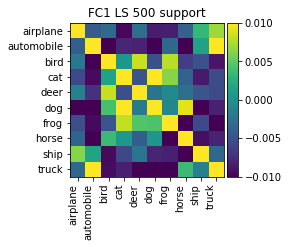

In [ ]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

fig, ax = plt.subplots(figsize=(3, 3))
im = ax.imshow(np.dot(y_support.T, solved_labels)/solved_labels.shape[0], 
               vmin=-0.01, vmax=0.01)
ax.set_xticks(range(10))
ax.set_yticks(range(10))
ax.set_xticklabels(class_names, rotation = 90, ha="right")
ax.set_yticklabels(class_names, rotation = 0, ha="right")
ax_divider = make_axes_locatable(ax)
# Add an axes to the right of the main axes.
cax = ax_divider.append_axes("right", size="7%", pad="2%")
fig.colorbar(im, cax=cax)
ax.set_title('FC1 LS 500 support')
plt.show()